In [83]:
import pandas as pd
import numpy as np
import ast
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [84]:
#Load data
data = pd.read_csv('Press_Conferences.csv', index_col=0, converters={"answer": ast.literal_eval})
#data = pd.read_csv('Press_Conferences.csv')

We'll need to Review The Scraper loop to avoid questions beeing incorrectly classified as MODERATOR

## Adapting Data for Preprocessing

In [85]:
import re

def correct_quoted_contractions(text):
    # Define a regular expression pattern to capture quoted expressions
    pattern = r'"([^"]*)"'
    
    # Define a replacement function to correct contractions
    def replace(match):
        return match.group(1).replace(' ', "'")
    
    # Apply the replacement function to the text using re.sub
    corrected_text = re.sub(pattern, replace, text)
    
    return corrected_text


def list_to_sentence(term_list):
    return ' '.join(term_list)

In [86]:
#Transform questions using Regex to leave only text
data['question'] = data['question'].str.replace(r"[\['\],]", ' ', regex=True)
data['question'] = data['question'].apply(lambda x: re.sub(' +', ' ', str(x).strip())) #Removes the additional empty spaces between words
data['question'] = data['question'].apply(correct_quoted_contractions)

In [87]:
#Split answer to player / answers then Transform answers using Regex to leave only text
data['player'] = [i for i,n in data['answer']]
data['reply'] = [n for i,n in data['answer']]
data = data.drop(['answer'],axis=1)
#Leave only text
data['reply_sentence'] = data['reply'].apply(list_to_sentence)
data = data.drop(['reply'],axis=1)

In [88]:
#Reseting Index for Date
data = data.reset_index()

## Transforming Dates

In [89]:
#data['date'] = pd.to_datetime(data['date'], format='%B %d, %Y').dt.strftime('%Y-%m-%d')

In [90]:
data['date'] = pd.to_datetime(data['date'], format='%B %d, %Y', errors='coerce')
data['date'] = pd.to_datetime(data['date'], errors='coerce')

#Create new columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['year_month'] = data['date'].dt.to_period('M')

### Create new Dataframe (df)

In [91]:
df = data[['date','year_month','year','month','player','question','reply_sentence']]
df


,date,year_month,year,month,player,question,reply_sentence
0,2024-03-03,2024-03,2024,3,rory mcilroy,a little bit of a race to the finish for you g...,a week that could have been i felt like most o...
1,2024-03-03,2024-03,2024,3,rory mcilroy,you added this event added valero to be sharpe...,yeah if anything i'm just learning sort of my ...
2,2024-03-03,2024-03,2024,3,rory mcilroy,unless you really think about your week you do...,i'm really happy i got done today because it m...
3,2024-03-03,2024-03,2024,3,rory mcilroy,with shane kind of in contention you're obviou...,it would mean a lot he loves this place and he...
4,2024-02-29,2024-02,2024,2,rory mcilroy,what did you think of your round today,pretty solid some good some not so good really...
...,...,...,...,...,...,...,...
19347,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,it could go two ways right something special g...
19348,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,yeah on i hit it to about an inch and justin t...
19349,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,nothing special what can we do go home have di...
19350,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,that's what we said it would have been so loud...


## Fixing Repeated Player Names

In [92]:
#Retrieving names for LIV PLAYERS

pattern = re.compile(r'^(ser|dust|phil|ian|talo|came|joa|bry|brook|jon)', flags=re.IGNORECASE)

# Loop over unique player names
for player_name in df['player'].unique():
    matches = pattern.findall(player_name)
    if matches:  # Check if the list of matches is not empty
        print(f"{player_name}: {matches}")

jon rahm: ['jon']
brooks koepka: ['brook']
cameron young: ['came']
sergio garcia: ['ser']
dustin johnson: ['dust']
phil mickelson: ['phil']
joaquin niemann: ['joa']
cameron smith: ['came']
talor gooch: ['talo']
sergio garcía: ['ser']
joaquín niemann: ['joa']
bryson dechambeau: ['bry']
cameron tringale: ['came']
ian poulter: ['ian']


In [93]:
df[df['player'].isin(['joaquín niemann','joaquin niemann','sergio garcía','sergio garcia'])].groupby('player').size()

player
joaquin niemann    371
joaquín niemann    120
sergio garcia      500
sergio garcía       16
dtype: int64

In [94]:
df['player'] = df['player'].replace('joaquín niemann','joaquin niemann').replace('sergio garcía','sergio garcia')

## EDA - RAW DATA

In [95]:
# Add new Dummy column (1: Currently in LIV, 0: Currently in PGA)
# List of players to check against
selected_players = ['sergio garcia', 'dustin johnson', 'phil mickelson', 'ian poulter', 'talor gooch',
                     'cameron smith', 'joaquin niemann', 'bryson dechambeau', 'brooks koepka', 'jon rahm']

# Create a dummy variable (1 if player is in the list, else 0)
df['LIV_Player'] = df['player'].isin(selected_players).astype(int)

In [96]:
# List of players and their corresponding specific dates
players_and_dates = {
    'sergio garcia': pd.to_datetime('2022-06-01'),
    'dustin johnson': pd.to_datetime('2022-06-01'),
    'phil mickelson': pd.to_datetime('2022-06-01'),
    'ian poulter': pd.to_datetime('2022-06-01'),
    'talor gooch': pd.to_datetime('2022-06-01'),
    'cameron smith': pd.to_datetime('2022-08-01'),
    'joaquin niemann': pd.to_datetime('2022-09-01'),
    'bryson dechambeau': pd.to_datetime('2022-06-20'),
    'brooks koepka': pd.to_datetime('2022-06-20'),
    'jon rahm': pd.to_datetime('2023-12-01'),
    # Add more players and dates as needed
}

# Create a binary variable (1 if player is in the list and date is after the specific date, else 0)
df['LIV_CHANGE'] = df.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['date'] > players_and_dates[row['player'].lower()]) else 0, axis=1)

In [97]:
#Create support table (includes unique players and it's current League affiliation)
player_league = df.groupby('player')['LIV_Player'].max().reset_index()

In [98]:
# How many answers per player
answer_players = df.groupby('player')['reply_sentence'].count().reset_index()
answer_players = answer_players.sort_values(by='reply_sentence',ascending=False)
answer_players['total'] = answer_players['reply_sentence'].sum()
answer_players['perc'] = (answer_players['reply_sentence'] / answer_players['total']).round(2)
answer_players['accum'] = answer_players['perc'].cumsum()

#Include LIV dummy
answer_players = answer_players.merge(player_league,how='left',on='player',suffixes=['labs'])
answer_players.head(18)

,player,reply_sentence,total,perc,accum,LIV_Player
0,rory mcilroy,2073,19352,0.11,0.11,0
1,scottie scheffler,1948,19352,0.10,0.21,0
2,jon rahm,1714,19352,0.09,0.30,1
3,jordan spieth,1371,19352,0.07,0.37,0
4,brooks koepka,1326,19352,0.07,0.44,1
5,dustin johnson,1280,19352,0.07,0.51,1
6,justin thomas,1279,19352,0.07,0.58,0
7,collin morikawa,1049,19352,0.05,0.63,0
8,cameron smith,927,19352,0.05,0.68,1
9,phil mickelson,841,19352,0.04,0.72,1


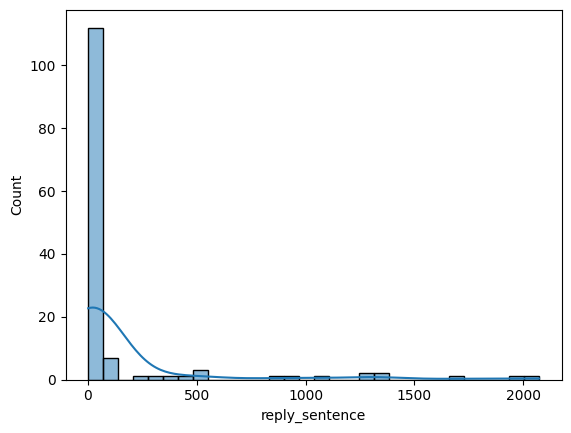

In [99]:
sns.histplot(data=answer_players, x='reply_sentence', bins=30,kde=True)
plt.show()

18/136 players represent 90% of all the replies.

### What is the proportion of LIV and PGA players from the TOP 18 players? 50 - 50

In [100]:
answer_players.head(18).groupby('LIV_Player')['player'].count()

LIV_Player
0     8
1    10
Name: player, dtype: int64

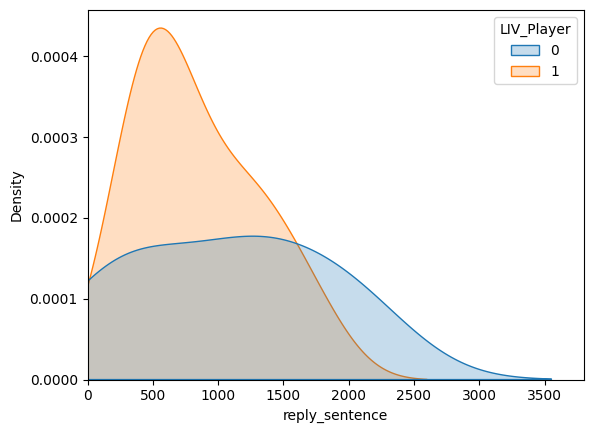

In [101]:
#sns.histplot(data=answer_players.head(18), x='reply_sentence', bins=30, hue='LIV_Player', kde=True)
sns.kdeplot(data=answer_players.head(18), x='reply_sentence', hue='LIV_Player', fill=True)
plt.xlim(0, None)
# Show the plot
plt.show()

Players of the PGA tour have a higher coverage of interviews than LIV players [OVERALL - past 4 years]. 

### How many players have given their answers consistently over time?

In [102]:
#Create support table (includes unique players and year-month)
top_players = answer_players['player'].head(18)
player_month = df[df['player'].isin(top_players)].groupby(['player','year_month'])['reply_sentence'].count().reset_index()
player_month = player_month.sort_values(by=['player','year_month'],ascending=[True,True])
#player_month

In [103]:
# Creating a Frequency table: Players (Rows) Dates (Columns)
frq_table = pd.crosstab(index=df['player'].astype(str), columns=df['year_month'].astype(str), margins=False).round(2)

### Number of Interviews per player per year-month

In [104]:
def count_nonzero_columns(row):
    return (row != 0).sum()

# Apply the function to each row and create a new column 'nonzero_count'
frq_table['nonzero_count'] = frq_table.apply(count_nonzero_columns, axis=1)
frq_table = frq_table.sort_values(by='nonzero_count',ascending=False)
frq_table.head(20)

year_month,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,...,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,nonzero_count
player,,,,,,,,,,,,,,,,,,,,,
rory mcilroy,38,0,22,9,64,27,36,87,74,63,...,56,98,83,38,21,0,69,25,4,35
jon rahm,47,0,7,16,54,62,38,87,34,78,...,67,71,60,12,13,0,20,69,20,34
justin thomas,40,0,55,39,82,69,28,25,27,19,...,11,0,14,28,0,20,11,25,5,33
jordan spieth,13,0,0,89,91,45,111,52,19,25,...,36,25,19,8,0,0,16,7,2,32
scottie scheffler,18,0,20,13,67,27,8,24,15,22,...,71,86,27,11,0,0,58,35,0,32
brooks koepka,30,0,11,37,0,34,76,77,27,13,...,16,5,64,90,0,0,0,36,0,29
dustin johnson,75,0,33,59,46,86,36,57,34,49,...,3,12,21,81,0,0,0,44,5,28
collin morikawa,13,16,71,0,8,44,53,65,50,10,...,16,37,29,0,0,0,38,0,0,27
cameron smith,21,0,27,0,35,98,13,13,15,17,...,32,0,18,28,0,0,0,0,0,24


In [105]:
#Retrieve Player order from Frequency table
frq_table_sub = frq_table[['nonzero_count']].reset_index()
frq_table_sub = frq_table_sub[['player','nonzero_count']]

#Merging
player_month = player_month.merge(frq_table_sub,how='left',on='player')

In [106]:
player_month = player_month.sort_values(by=['nonzero_count','player','year_month'],ascending=[False,False,True])
player_month_top = player_month[player_month['nonzero_count'] >= 22]
#player_month_top

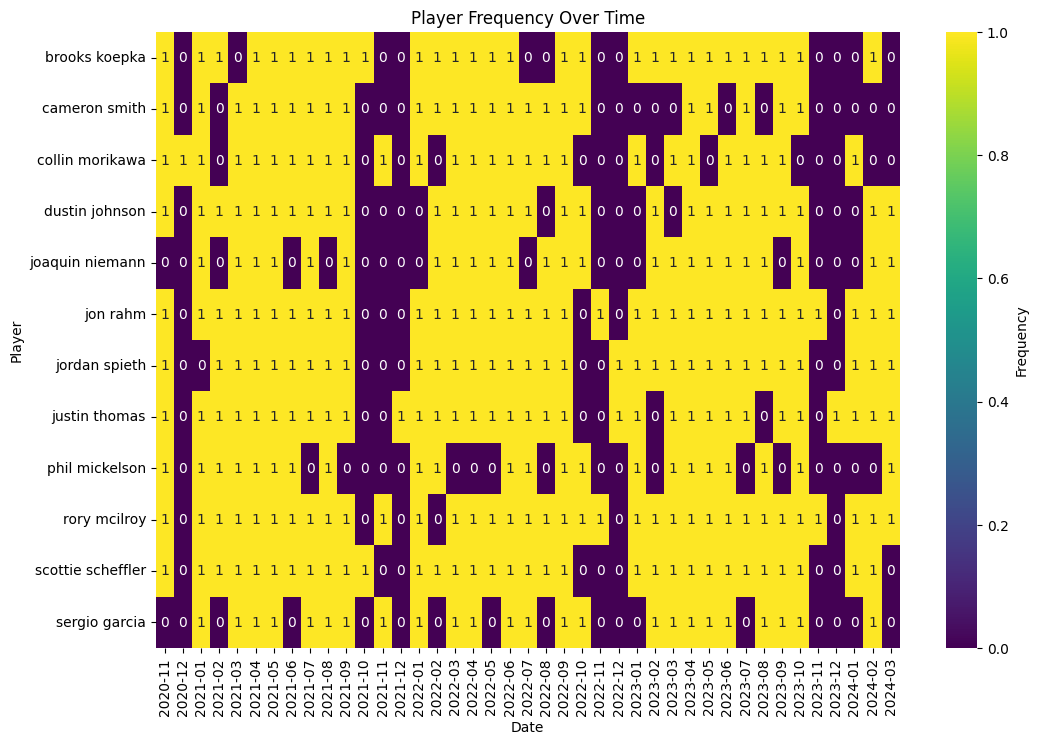

In [107]:
pivot_table = player_month_top.pivot_table(index='player', columns='year_month', values='reply_sentence', aggfunc='count', fill_value=0)

# Create a heatmap plot
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='g', cbar_kws={'label': 'Frequency'})

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Player')
plt.title('Player Frequency Over Time')

# Show the plot
plt.show()


We can see a clear seasonality in the last 3 months of the years, probably there are no events during those months.

### Final selection of players for analysis:

In [108]:
analysis_list = player_month_top['player'].unique().tolist()
analysis_list

['rory mcilroy',
 'jon rahm',
 'justin thomas',
 'scottie scheffler',
 'jordan spieth',
 'brooks koepka',
 'dustin johnson',
 'collin morikawa',
 'sergio garcia',
 'joaquin niemann',
 'cameron smith',
 'phil mickelson']

In [109]:
df_pre = df[df['player'].isin(analysis_list)]

In [110]:
Player_leagues = df_pre.groupby('LIV_Player')['player'].unique()
print('PGA: ',len(Player_leagues[0]))
print(Player_leagues[0])
print('LIV: ',len(Player_leagues[1]))
print(Player_leagues[1])
#Player_affiliation = pd.DataFrame({'PGA':Player_leagues[0].tolist(),'LIV':Player_leagues[1].tolist()})
#Player_affiliation

PGA:  5
['rory mcilroy' 'jordan spieth' 'justin thomas' 'scottie scheffler'
 'collin morikawa']
LIV:  7
['jon rahm' 'brooks koepka' 'sergio garcia' 'dustin johnson'
 'phil mickelson' 'joaquin niemann' 'cameron smith']


In [111]:
df_pre

,date,year_month,year,month,player,question,reply_sentence,LIV_Player,LIV_CHANGE
0,2024-03-03,2024-03,2024,3,rory mcilroy,a little bit of a race to the finish for you g...,a week that could have been i felt like most o...,0,0
1,2024-03-03,2024-03,2024,3,rory mcilroy,you added this event added valero to be sharpe...,yeah if anything i'm just learning sort of my ...,0,0
2,2024-03-03,2024-03,2024,3,rory mcilroy,unless you really think about your week you do...,i'm really happy i got done today because it m...,0,0
3,2024-03-03,2024-03,2024,3,rory mcilroy,with shane kind of in contention you're obviou...,it would mean a lot he loves this place and he...,0,0
4,2024-02-29,2024-02,2024,2,rory mcilroy,what did you think of your round today,pretty solid some good some not so good really...,0,0
...,...,...,...,...,...,...,...,...,...
19347,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,it could go two ways right something special g...,1,0
19348,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,yeah on i hit it to about an inch and justin t...,1,0
19349,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,nothing special what can we do go home have di...,1,0
19350,2020-11-10,2020-11,2020,11,jon rahm,MODERATOR,that's what we said it would have been so loud...,1,0


### MODERATOR questions represent up to 29% in some cases. WE SHOULD TRY FIX IT

In [112]:
players = []
counter = 0
for i,n in zip(df_pre['question'],df_pre['player']):
    if i =='MODERATOR':
        counter+=1
        players.append(n)

#Counting distinct values

counts = Counter(players)
table = pd.DataFrame(list(counts.items()), columns=['Value', 'Count'])

#Calculating number of questions per player
table2 = df_pre.groupby('player')['question'].count().reset_index()

#Merging
table = table.merge(table2,how='left',left_on='Value',right_on='player')
table = table.drop(['player'],axis=1)
table['perc_Moderator'] = table['Count']/table['question']
table.sort_values(by='perc_Moderator',ascending=False).round(2)


,Value,Count,question,perc_Moderator
8,joaquin niemann,142,491,0.29
6,dustin johnson,321,1280,0.25
10,brooks koepka,290,1326,0.22
5,sergio garcia,110,516,0.21
7,phil mickelson,177,841,0.21
9,cameron smith,170,927,0.18
2,justin thomas,159,1279,0.12
11,jon rahm,213,1714,0.12
4,collin morikawa,126,1049,0.12
1,jordan spieth,134,1371,0.10


## Aggregating by player and Month

In [113]:
monthly_aggregated_reply = df_pre.groupby(['player', 'year_month'])['reply_sentence'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_interviews')
monthly_aggregated_quest = df_pre.groupby(['player', 'year_month'])['question'].agg(lambda x: ' '.join(x)).reset_index(name='concatenated_questions')

In [114]:
#merging concatenated replies and questions
df_month = monthly_aggregated_reply.merge(monthly_aggregated_quest,how='left',on=['player','year_month'],suffixes=('sub','ex'))


In [115]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype    
---  ------                   --------------  -----    
 0   player                   344 non-null    object   
 1   year_month               344 non-null    period[M]
 2   concatenated_interviews  344 non-null    object   
 3   concatenated_questions   344 non-null    object   
dtypes: object(3), period[M](1)
memory usage: 10.9+ KB


In [116]:
# List of players and their corresponding specific dates
players_and_dates = {
    'sergio garcia': pd.Period('2022-06'),
    'dustin johnson': pd.Period('2022-06'),
    'phil mickelson': pd.Period('2022-06'),
    'ian poulter': pd.Period('2022-06'),
    'talor gooch': pd.Period('2022-06'),
    'cameron smith': pd.Period('2022-08'),
    'joaquin niemann': pd.Period('2022-09'),
    'bryson dechambeau': pd.Period('2022-06'),
    'brooks koepka': pd.Period('2022-06'),
    'jon rahm': pd.Period('2023-12'),
    # Add more players and dates as needed
}
df_month['LIV_CHANGE'] = df_month.apply(lambda row: 1 if (row['player'].lower() in players_and_dates and row['year_month'] == players_and_dates[row['player'].lower()]) else 0, axis=1)
df_month

,player,year_month,concatenated_interviews,concatenated_questions,LIV_CHANGE
0,brooks koepka,2020-11,i mean i wouldn't call them steady they're pre...,MODERATOR MODERATOR MODERATOR MODERATOR MODERA...,0
1,brooks koepka,2021-01,yeah it was nice spent a few weeks at home and...,MODERATOR MODERATOR MODERATOR can you give me ...,0
2,brooks koepka,2021-02,yeah i love this place this golf course is alw...,MODERATOR MODERATOR MODERATOR so you had i gue...,0
3,brooks koepka,2021-04,i missed the cut so it isn't very good is it p...,assess how the last two days went overall just...,0
4,brooks koepka,2021-05,just how bad i putted the last two days three ...,MODERATOR MODERATOR MODERATOR MODERATOR that b...,0
...,...,...,...,...,...
339,sergio garcia,2023-06,yeah thank you it was great to see to see the ...,MODERATOR MODERATOR you've played here times a...,0
340,sergio garcia,2023-08,yeah i saw him in the locker room after he did...,MODERATOR MODERATOR there's only three tournam...,0
341,sergio garcia,2023-09,great day obviously started really well my fir...,MODERATOR MODERATOR MODERATOR with it being su...,0
342,sergio garcia,2023-10,no i think that you can look at it both ways i...,MODERATOR bryson last year you guys weren't ab...,0


## PREPROCESSING

In [117]:
# We'll be working with df_month
#Directory
import os
# Storing Data
import csv
# Tracking loading progress
from tqdm import tqdm
tqdm.pandas()
# Preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords # Add MODERATOR TO THE STOPWORDS LIST
#!python -m spacy download en_core_web_sm
import spacy
import pickle
sp = spacy.load('en_core_web_sm')
#Regex
import re

#Plotting
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

#set paths for input and output
path='/Users/mikelgallo/repos2/pga_liv/'
spitout='//Users/mikelgallo/repos2/pga_liv/RESULT'

## OWN Functions
import prepr_functions
from prepr_functions import *


In [118]:
#Checking Results from Preprocessing Modules
testing = txtprocess_tok(df_month[0:20],'concatenated_questions',1)
for i in testing:
    print(i)

100%|██████████| 20/20 [00:00<00:00, 727.52it/s]


give idea look back last year feel like need turn around simpl healthi feel like go fine prp apolog know sit begin season think goal want accomplish straightforward finish tournament might want finish statist ever sit think want statist far hard number like golf ball speed clubhead speed never radar come statist like worri stroke gain distanc anyth els along line look like schedul littl differ year begin year never play play san diego next week farmer could talk littl bit think put schedul togeth earli part year year say win breed confid would say confid level right would victori week mean confid go forward surpris go need littl treatment think need futur treatment cours season knee would success look like
guess month injur fan injuri wors fan sort ad insult injuri suppos feel like got fan sort back brook koepka secondarili feel like got sniff lead would respond way today congratul brook mention dark place tough time share realli like rememb low point lowest moment focus around major 

In [119]:
## Preprocesing both interviews and questions
df_month['interv_prepr'] = txtprocess_tok(df_month,'concatenated_interviews',1)
df_month['quest_prepr'] = txtprocess_tok(df_month,'concatenated_questions',1)

#Assembling the new dataframe with both preprocessed and original columns
df_month  = df_month[['player', 'year_month','quest_prepr', 'interv_prepr', 'LIV_CHANGE','concatenated_questions','concatenated_interviews']]
df_month.head()

100%|██████████| 344/344 [00:00<00:00, 545.68it/s]


,player,year_month,quest_prepr,interv_prepr,LIV_CHANGE,concatenated_questions,concatenated_interviews
0,brooks koepka,2020-11,,mean call steadi pretti sloppi give away shot ...,0,MODERATOR MODERATOR MODERATOR MODERATOR MODERA...,i mean i wouldn't call them steady they're pre...
1,brooks koepka,2021-01,give idea look back last year feel like need t...,yeah nice spent week home right new year came ...,0,MODERATOR MODERATOR MODERATOR can you give me ...,yeah it was nice spent a few weeks at home and...
2,brooks koepka,2021-02,guess month injur fan injuri wors fan sort ad ...,yeah love place golf cours alway fun happi mak...,0,MODERATOR MODERATOR MODERATOR so you had i gue...,yeah i love this place this golf course is alw...
3,brooks koepka,2021-04,assess last two day went overal play today rou...,miss cut good putter ice cold make putt want s...,0,assess how the last two days went overall just...,i missed the cut so it isn't very good is it p...
4,brooks koepka,2021-05,said look whole weekend satisfi weekend consid...,bad put last two day three day actual felt lik...,0,MODERATOR MODERATOR MODERATOR MODERATOR that b...,just how bad i putted the last two days three ...


In [120]:
#Add the length of the documents 

df_month['quest_prep_len'] = [len(i.split(' ')) for i in df_month['quest_prepr']]
df_month['interv_prep_len'] = [len(i.split(' ')) for i in df_month['interv_prepr']]

df_month['quest_len'] = [len(i.split(' ')) for i in df_month['concatenated_questions']]
df_month['reply_len'] = [len(i.split(' ')) for i in df_month['concatenated_interviews']]
df_month.head()
#print(len(df_month.concatenated_questions[40].split(' ')))
#print(len(df_month.quest_prepr[40].split(' ')))

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_76830/2797697732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['quest_prep_len'] = [len(i.split(' ')) for i in df_month['quest_prepr']]
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_76830/2797697732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['interv_prep_len'] = [len(i.split(' ')) for i in df_month['interv_prepr']]
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_76830/2797697732.py:6: SettingW

,player,year_month,quest_prepr,interv_prepr,LIV_CHANGE,concatenated_questions,concatenated_interviews,quest_prep_len,interv_prep_len,quest_len,reply_len
0,brooks koepka,2020-11,,mean call steadi pretti sloppi give away shot ...,0,MODERATOR MODERATOR MODERATOR MODERATOR MODERA...,i mean i wouldn't call them steady they're pre...,1,955,30,2158
1,brooks koepka,2021-01,give idea look back last year feel like need t...,yeah nice spent week home right new year came ...,0,MODERATOR MODERATOR MODERATOR can you give me ...,yeah it was nice spent a few weeks at home and...,121,332,262,733
2,brooks koepka,2021-02,guess month injur fan injuri wors fan sort ad ...,yeah love place golf cours alway fun happi mak...,0,MODERATOR MODERATOR MODERATOR so you had i gue...,yeah i love this place this golf course is alw...,294,1100,675,2440
3,brooks koepka,2021-04,assess last two day went overal play today rou...,miss cut good putter ice cold make putt want s...,0,assess how the last two days went overall just...,i missed the cut so it isn't very good is it p...,229,665,525,1584
4,brooks koepka,2021-05,said look whole weekend satisfi weekend consid...,bad put last two day three day actual felt lik...,0,MODERATOR MODERATOR MODERATOR MODERATOR that b...,just how bad i putted the last two days three ...,647,2008,1561,4700


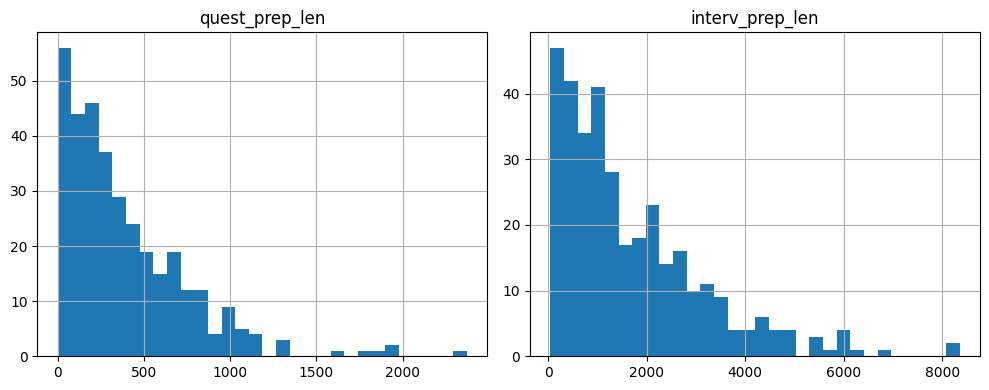

In [121]:
def numeric_cols(dataset):
    numerics = dataset.select_dtypes(include= np.number).columns.tolist()
    return numerics

def plot_hist_mult(data,var1,var2,bins):
    fig, axes = plt.subplots(var1,var2)

    for i, el in enumerate(list(data.columns.values)):
        a= data.hist(el,ax=axes.flatten()[i], bins=bins)

    fig.set_size_inches(10,4)
    plt.tight_layout()
    plt.show()

numeric_cols = numeric_cols(df_month)
filtered_cols = [i for i in numeric_cols if i not in ['LIV_CHANGE','quest_len','reply_len']]

plot_hist_mult(df_month[filtered_cols],1,2,30)

In [122]:
freq_qt = df_month.groupby('quest_prep_len')['player'].count().reset_index()
freq_qt = freq_qt.sort_values(by='quest_prep_len',ascending=True)
print(freq_qt[0:10])
freq_an = df_month.groupby('interv_prep_len')['player'].count().reset_index()
freq_an = freq_an.sort_values(by='interv_prep_len',ascending=True)
print(freq_an[0:10])

   quest_prep_len  player
0               1      11
1               7       1
2              13       2
3              15       1
4              16       1
5              17       2
6              25       1
7              26       1
8              28       2
9              30       2
   interv_prep_len  player
0               45       1
1               60       1
2               66       1
3               70       2
4               71       1
5              100       1
6              116       1
7              121       1
8              126       1
9              136       1


Let's Review those rows with empty questions.
Interviews have plenty of words compared to our question preprocessor.

## DTM for Questions

First we create a vocab for questions

In [123]:
%%time
#build vocabulary
vocab, index = {}, 1  # start indexing from 1
for doc in df_month.quest_prepr:
    #print(doc)
    tokens = doc.split()
    for token in tokens:
      if token not in vocab:
        vocab[token] = index
        index += 1

vocab_low=vocab
vocab_low_size = len(vocab)
print(vocab_low)
print(" ")
print("Total size of lower vocabulary:", vocab_low_size)


vectors=[]
for doc in df_month.quest_prepr:
    vectors.append(vectorize(doc, vocab_low))

df_q_matrix = pd.DataFrame(vectors)
df_q_matrix


{'give': 1, 'idea': 2, 'look': 3, 'back': 4, 'last': 5, 'year': 6, 'feel': 7, 'like': 8, 'need': 9, 'turn': 10, 'around': 11, 'simpl': 12, 'healthi': 13, 'go': 14, 'fine': 15, 'prp': 16, 'apolog': 17, 'know': 18, 'sit': 19, 'begin': 20, 'season': 21, 'think': 22, 'goal': 23, 'want': 24, 'accomplish': 25, 'straightforward': 26, 'finish': 27, 'tournament': 28, 'might': 29, 'statist': 30, 'ever': 31, 'far': 32, 'hard': 33, 'number': 34, 'golf': 35, 'ball': 36, 'speed': 37, 'clubhead': 38, 'never': 39, 'radar': 40, 'come': 41, 'worri': 42, 'stroke': 43, 'gain': 44, 'distanc': 45, 'anyth': 46, 'els': 47, 'along': 48, 'line': 49, 'schedul': 50, 'littl': 51, 'differ': 52, 'play': 53, 'san': 54, 'diego': 55, 'next': 56, 'week': 57, 'farmer': 58, 'could': 59, 'talk': 60, 'bit': 61, 'put': 62, 'togeth': 63, 'earli': 64, 'part': 65, 'say': 66, 'win': 67, 'breed': 68, 'confid': 69, 'would': 70, 'level': 71, 'right': 72, 'victori': 73, 'mean': 74, 'forward': 75, 'surpris': 76, 'treatment': 77, 'fut

,0,1,2,3,4,5,6,7,8,9,...,5478,5479,5480,5481,5482,5483,5484,5485,5486,5487
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3,1,1,5,2,6,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,5,0,0,13,14,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,2,0,1,1,5,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,8,9,7,3,6,17,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1,0,1,2,0,3,4,3,0,0,...,1,2,1,0,0,0,0,0,0,0
340,1,0,1,2,2,6,1,7,0,0,...,0,0,0,1,1,1,1,1,1,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,1,16,17,6,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [124]:
df_q_matrix.columns = vocab_low.keys()
df_q_matrix

,give,idea,look,back,last,year,feel,like,need,turn,...,gonzález,multiyear,andalucía,crown,bye,revamp,formal,mcafe,pike,geno
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,3,1,1,5,2,6,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,5,0,0,13,14,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,2,0,1,1,5,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,8,9,7,3,6,17,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1,0,1,2,0,3,4,3,0,0,...,1,2,1,0,0,0,0,0,0,0
340,1,0,1,2,2,6,1,7,0,0,...,0,0,0,1,1,1,1,1,1,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,1,16,17,6,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [125]:
norm_dtm = normalize_vectors(df_q_matrix)
norm_dtm

,give,idea,look,back,last,year,feel,like,need,turn,...,gonzález,multiyear,andalucía,crown,bye,revamp,formal,mcafe,pike,geno
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.008815,0.008815,0.026446,0.008815,0.008815,0.044077,0.017631,0.052893,0.026446,0.008815,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.019735,0.000000,0.000000,0.051311,0.055257,0.003947,0.000000,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.004946,0.000000,0.009892,0.000000,0.004946,0.004946,0.024729,0.014837,0.000000,0.000000,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.005403,0.000000,0.014407,0.016208,0.012606,0.005403,0.010805,0.030615,0.007203,0.000000,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.007500,0.000000,0.007500,0.015000,0.000000,0.022500,0.030000,0.022500,0.000000,0.000000,...,0.0075,0.015,0.0075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
340,0.003608,0.000000,0.003608,0.007217,0.007217,0.021651,0.003608,0.025259,0.000000,0.000000,...,0.0000,0.000,0.0000,0.003608,0.003608,0.003608,0.003608,0.003608,0.003608,0.000000
341,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
342,0.000000,0.000000,0.000000,0.004781,0.076501,0.081282,0.028688,0.000000,0.000000,0.000000,...,0.0000,0.000,0.0000,0.004781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [126]:
df_q_matrix1 = df_q_matrix.copy()

for column in df_q_matrix1.columns:
    for index, value in df_q_matrix1[column].items():
        if value > 0:
            df_q_matrix1.at[index, column] = 1
        else:
            df_q_matrix1.at[index, column] = 0

df_q_matrix1

,give,idea,look,back,last,year,feel,like,need,turn,...,gonzález,multiyear,andalucía,crown,bye,revamp,formal,mcafe,pike,geno
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1,0,1,1,0,1,1,1,0,0,...,1,1,1,0,0,0,0,0,0,0
340,1,0,1,1,1,1,1,1,0,0,...,0,0,0,1,1,1,1,1,1,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,1,1,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


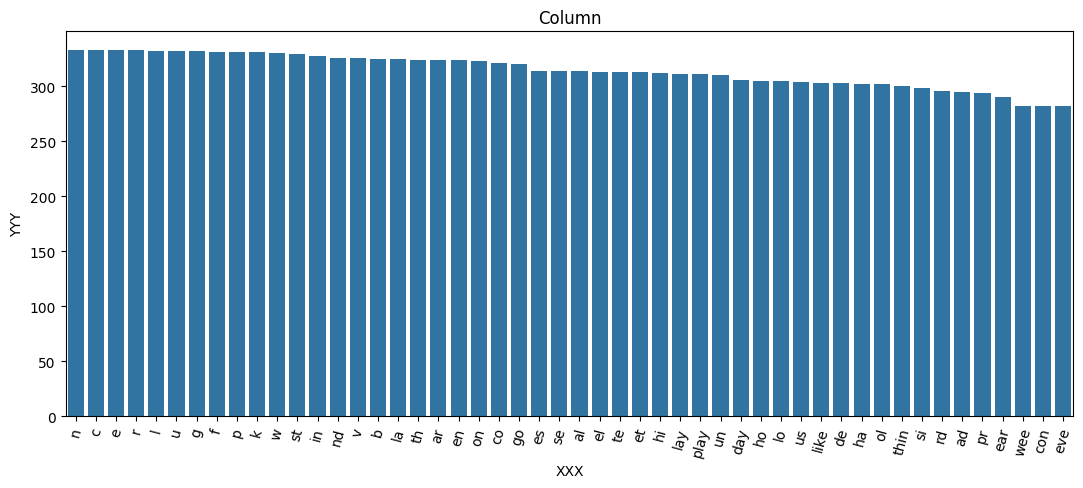

In [127]:
term_appearances = df_q_matrix.sum(axis=0).reset_index()
term_appearances_bi = df_q_matrix1.sum(axis=0).reset_index()

#Merge both df
merged_term_appearances = term_appearances.merge(term_appearances_bi,how='left',on='index',suffixes=('freq','docs'))
merged_term_appearances = merged_term_appearances.sort_values(by='0docs',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances.head(50), x='index', y='0docs')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

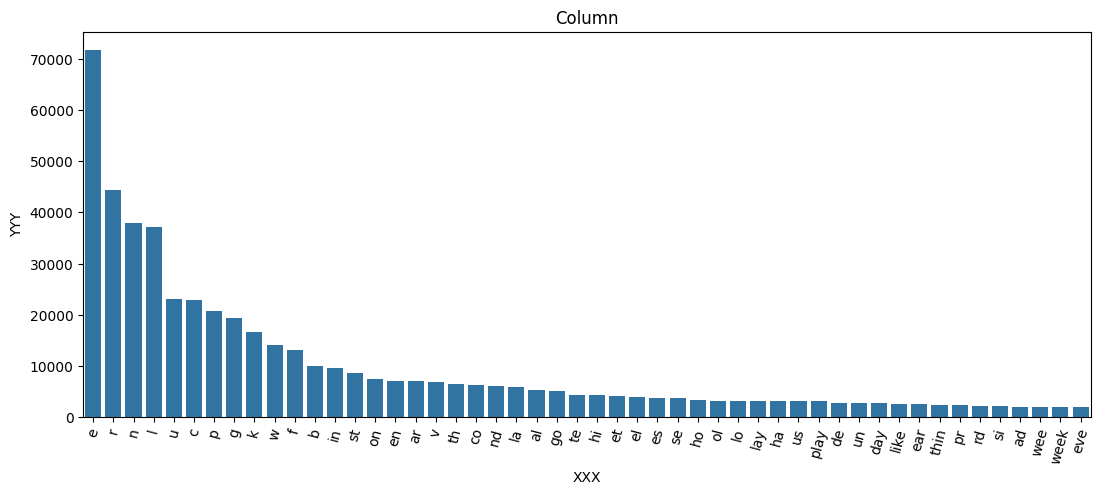

In [128]:
merged_term_appearances = merged_term_appearances.sort_values(by='0freq',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances.head(50), x='index', y='0freq')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

## Use CountVectorizer() for Questions
Using CountVectorizer we managed to reduce the number of terms from 8047 to 864

In [129]:
cv = CountVectorizer(ngram_range = (1,3),  min_df=0.1,max_df=0.7, stop_words='english')
cv.fit(df_month['concatenated_questions'])
vectorized_text=cv.transform(df_month['quest_prepr'])
vectorized_text=vectorized_text.todense()

dtm_df = pd.DataFrame(vectorized_text, columns=cv.get_feature_names_out())

print("document term matrix has size", vectorized_text.shape)
print(cv.get_feature_names_out())

document term matrix has size (344, 462)
['able' 'actually' 'advantage' 'advice' 'affect' 'afternoon' 'ago' 'ahead'
 'approach' 'ask' 'asked' 'assess' 'attention' 'augusta' 'aware' 'away'
 'bad' 'ball' 'best' 'better' 'big' 'biggest' 'birdie' 'birdies' 'bit'
 'bogey' 'break' 'bring' 'brooks' 'bryson' 'came' 'captain' 'career'
 'case' 'challenge' 'champion' 'champions' 'championship' 'chance'
 'change' 'changed' 'changes' 'chip' 'close' 'club' 'come' 'comes'
 'comfortable' 'coming' 'comments' 'compare' 'compared' 'competition'
 'conditions' 'confidence' 'consider' 'contention' 'couple' 'couple days'
 'couple weeks' 'courses' 'crowd' 'cup' 'curious' 'cut' 'dad' 'day' 'days'
 'deal' 'decision' 'did feel' 'did feel like' 'did think' 'didn'
 'difference' 'different' 'differently' 'difficult' 'dinner' 'does feel'
 'does make' 'does mean' 'doesn' 'doing' 'don' 'don know' 'drive' 'driver'
 'eagle' 'earlier' 'early' 'easier' 'easy' 'emotions' 'end' 'energy'
 'enjoy' 'especially' 'european' 'eve

In [130]:
dtm_df

,able,actually,advantage,advice,affect,afternoon,ago,ahead,approach,ask,...,work,working,world,wouldn,yeah,year,years,years ago,yesterday,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,2,0,0,0,2,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,2,0,0,0,4,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
340,0,0,0,0,0,0,0,0,0,2,...,0,0,2,0,0,6,0,0,1,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,17,0,0,0,0


In [131]:
df_q_matrix2 = dtm_df.copy()

for column in df_q_matrix2.columns:
    for index, value in df_q_matrix2[column].items():
        if value > 0:
            df_q_matrix2.at[index, column] = 1
        else:
            df_q_matrix2.at[index, column] = 0

df_q_matrix2

,able,actually,advantage,advice,affect,afternoon,ago,ahead,approach,ask,...,work,working,world,wouldn,yeah,year,years,years ago,yesterday,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
340,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
342,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


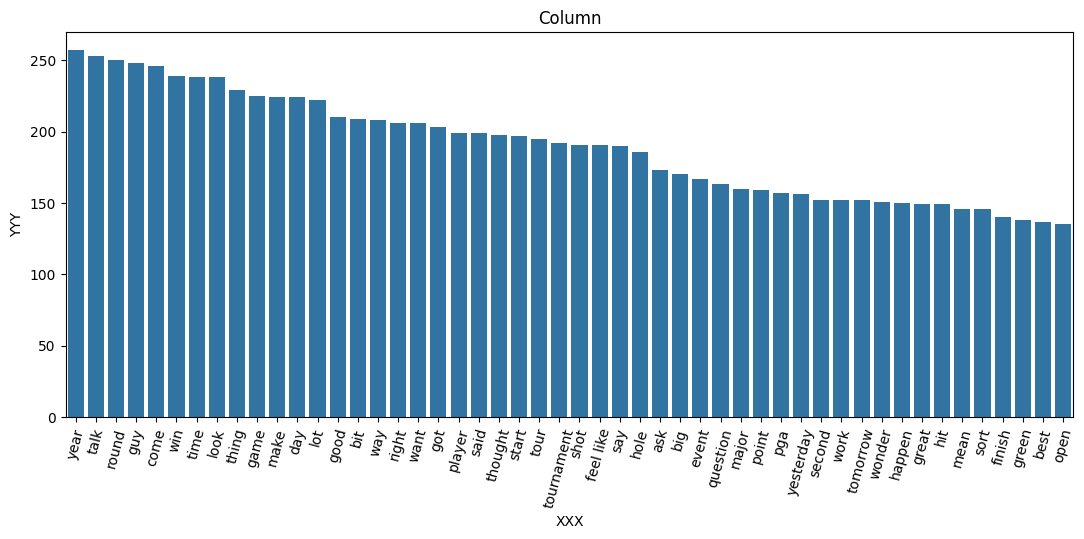

In [132]:
term_appearances2 = dtm_df.sum(axis=0).reset_index()
term_appearances_bi2 = df_q_matrix2.sum(axis=0).reset_index()

merged_term_appearances2 = term_appearances2.merge(term_appearances_bi2,how='left',on='index',suffixes=('freq','docs'))
merged_term_appearances2 = merged_term_appearances2.sort_values(by='0docs',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances2.head(50), x='index', y='0docs')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

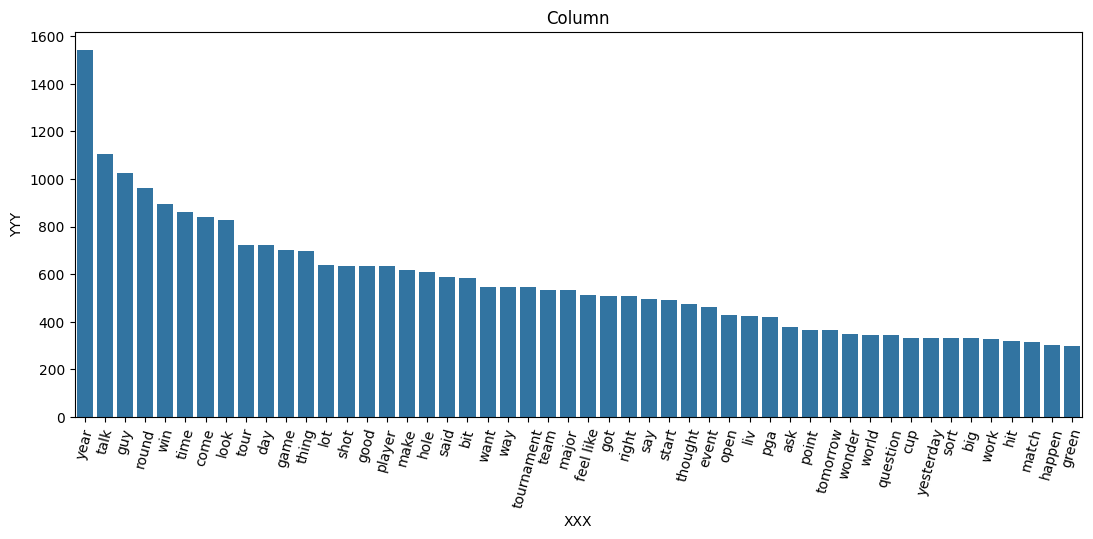

In [133]:
merged_term_appearances2 = merged_term_appearances2.sort_values(by='0freq',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances2.head(50), x='index', y='0freq')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

## Try TF-IDF on Questions
Does  normalization + term ranking

In [145]:
td = TfidfVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.9, stop_words='english', norm='l2')
td.fit(df_month['concatenated_questions'])
tf_idf_txt=td.transform(df_month['quest_prepr'])
tf_idf_txt=tf_idf_txt.todense()
print("document term matrix has size", tf_idf_txt.shape)
print(td.get_feature_names_out())

document term matrix has size (344, 985)
['able' 'actually' 'adam' 'advantage' 'advice' 'affect' 'afternoon' 'age'
 'aggressive' 'ago' 'ahead' 'amateur' 'amazing' 'american' 'announced'
 'answer' 'anybody' 'approach' 'area' 'aren' 'ask' 'asked' 'asking'
 'aspect' 'assess' 'assess round' 'assessment' 'assuming' 'atmosphere'
 'attention' 'attitude' 'augusta' 'augusta national' 'aware' 'away' 'bad'
 'bag' 'balance' 'ball' 'balls' 'based' 'basically' 'battle' 'bay' 'beat'
 'beginning' 'believe' 'best' 'better' 'big' 'bigger' 'biggest' 'birdie'
 'birdies' 'bit' 'board' 'bogey' 'bogeys' 'bounce' 'break' 'bring'
 'brooks' 'brought' 'bryson' 'build' 'bunch' 'bunker' 'business' 'caddie'
 'calendar' 'called' 'calm' 'cam' 'came' 'captain' 'care' 'career' 'carry'
 'case' 'catch' 'certain' 'certainly' 'challenge' 'challenges'
 'challenging' 'champion' 'champions' 'championship' 'championships'
 'chance' 'chance win' 'chances' 'change' 'changed' 'changes' 'changing'
 'characterize' 'chase' 'chip' 'c

In [146]:
dft_df = pd.DataFrame(tf_idf_txt, columns=td.get_feature_names_out())
dft_df

,able,actually,adam,advantage,advice,affect,afternoon,age,aggressive,ago,...,year just,year ve,year year,years,years ago,years ve,yes,yesterday,young,younger
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.153119,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.070549,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.039006,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.099847,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.026922,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
340,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.035419,0.000000,0.0
341,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
342,0.0,0.0,0.0,0.0,0.0,0.257549,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.069939,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [147]:
df_q_matrix3 = dft_df.copy()

for column in df_q_matrix3.columns:
    for index, value in df_q_matrix3[column].items():
        if value > 0:
            df_q_matrix3.at[index, column] = 1
        else:
            df_q_matrix3.at[index, column] = 0

df_q_matrix3

,able,actually,adam,advantage,advice,affect,afternoon,age,aggressive,ago,...,year just,year ve,year year,years,years ago,years ve,yes,yesterday,young,younger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
342,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


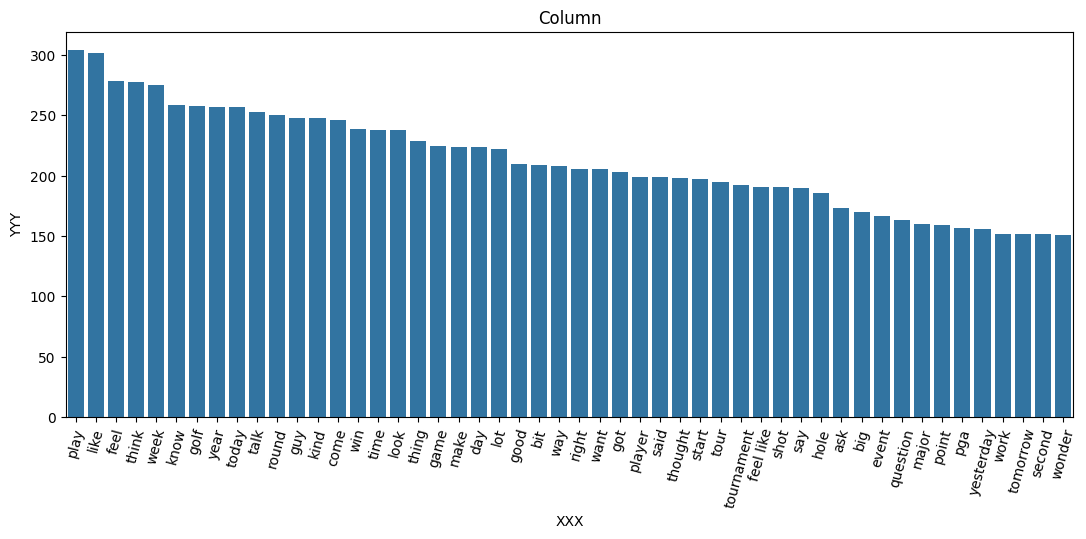

In [148]:
term_appearances3 = dft_df.sum(axis=0).reset_index()
term_appearances_bi3 = df_q_matrix3.sum(axis=0).reset_index()

merged_term_appearances3 = term_appearances3.merge(term_appearances_bi3,how='left',on='index',suffixes=('freq','docs'))
merged_term_appearances3 = merged_term_appearances3.sort_values(by='0docs',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances3.head(50), x='index', y='0docs')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

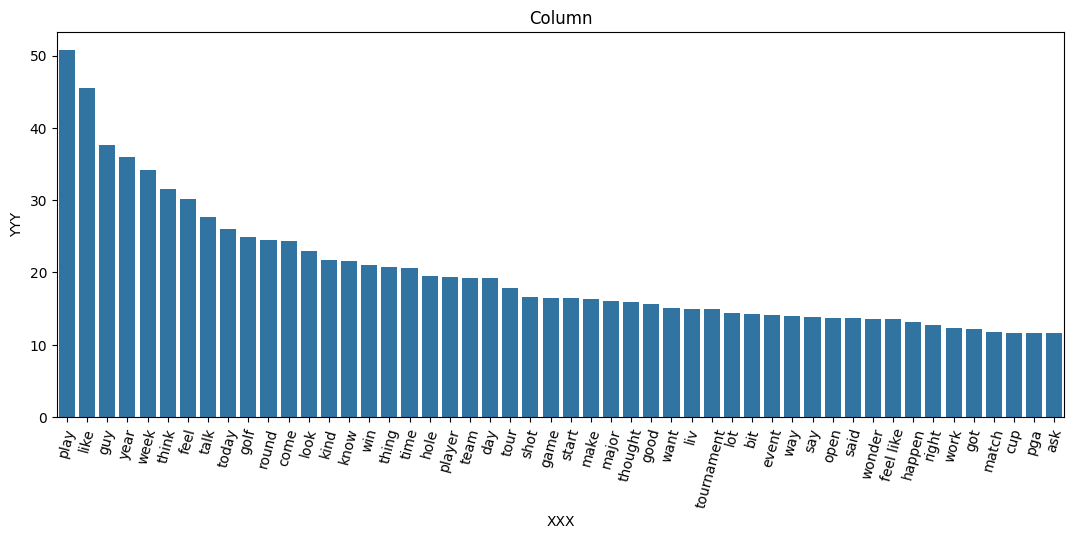

In [149]:
merged_term_appearances3 = merged_term_appearances3.sort_values(by='0freq',ascending=False)

#Plotting variables with many unique values

# Create a bar plot
plt.figure(figsize=(13, 5))
sns.barplot(data=merged_term_appearances3.head(50), x='index', y='0freq')
plt.xticks(rotation=75)
plt.title('Column')
plt.xlabel('XXX')
plt.ylabel('YYY')
plt.show()

## Applying LDA for Topic Retrieval

In [150]:
from sklearn.decomposition import LatentDirichletAllocation

In [153]:
# Specify the number of topics (adjust as needed)
num_topics = 10

# Initialize LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the model to your TF-IDF matrix
lda.fit(dft_df)


LatentDirichletAllocation(random_state=42)

In [154]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# Get feature names from TF-IDF matrix
feature_names = td.get_feature_names_out()

# Print top words for each topic
print_top_words(lda, feature_names, n_top_words=10)


Topic #1: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #2: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #3: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #4: play, like, guy, year, week, think, feel, talk, today, golf
Topic #5: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #6: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #7: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #8: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #9: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon
Topic #10: realize, consider, tight, later, mix, younger, straight, mickelson, amateur, afternoon


In [155]:
# Assuming 'lda' is your trained LDA model
topic_assignments = lda.transform(dft_df)

# Find the dominant topic for each document
dominant_topics = [topic_idx.argmax() for topic_idx in topic_assignments]

# Add a new column 'topic_label' to your original DataFrame
df_month['topic_label'] = dominant_topics

# Display the document with their assigned topic labels
df_month

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_76830/3457087959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_month['topic_label'] = dominant_topics


,player,year_month,quest_prepr,interv_prepr,LIV_CHANGE,concatenated_questions,concatenated_interviews,quest_prep_len,interv_prep_len,quest_len,reply_len,topic_label
0,brooks koepka,2020-11,,mean call steadi pretti sloppi give away shot ...,0,MODERATOR MODERATOR MODERATOR MODERATOR MODERA...,i mean i wouldn't call them steady they're pre...,1,955,30,2158,0
1,brooks koepka,2021-01,give idea look back last year feel like need t...,yeah nice spent week home right new year came ...,0,MODERATOR MODERATOR MODERATOR can you give me ...,yeah it was nice spent a few weeks at home and...,121,332,262,733,3
2,brooks koepka,2021-02,guess month injur fan injuri wors fan sort ad ...,yeah love place golf cours alway fun happi mak...,0,MODERATOR MODERATOR MODERATOR so you had i gue...,yeah i love this place this golf course is alw...,294,1100,675,2440,3
3,brooks koepka,2021-04,assess last two day went overal play today rou...,miss cut good putter ice cold make putt want s...,0,assess how the last two days went overall just...,i missed the cut so it isn't very good is it p...,229,665,525,1584,3
4,brooks koepka,2021-05,said look whole weekend satisfi weekend consid...,bad put last two day three day actual felt lik...,0,MODERATOR MODERATOR MODERATOR MODERATOR that b...,just how bad i putted the last two days three ...,647,2008,1561,4700,3
...,...,...,...,...,...,...,...,...,...,...,...,...
339,sergio garcia,2023-06,play time got top finish three win toughest se...,yeah thank great see see crowd got obvious ama...,0,MODERATOR MODERATOR you've played here times a...,yeah thank you it was great to see to see the ...,139,653,322,1547,3
340,sergio garcia,2023-08,three tournament remain regular season crown i...,yeah saw locker room media stuff flew back aus...,0,MODERATOR MODERATOR there's only three tournam...,yeah i saw him in the locker room after he did...,316,896,691,2057,3
341,sergio garcia,2023-09,tight spread top tomorrow get front pack jed k...,great day obvious start realli well first prob...,0,MODERATOR MODERATOR MODERATOR with it being su...,great day obviously started really well my fir...,16,126,47,274,3
342,sergio garcia,2023-10,bryson last year guy abl get semifin got lineu...,think look way think obvious nice come tomorro...,0,MODERATOR bryson last year you guys weren't ab...,no i think that you can look at it both ways i...,229,1739,534,3891,3


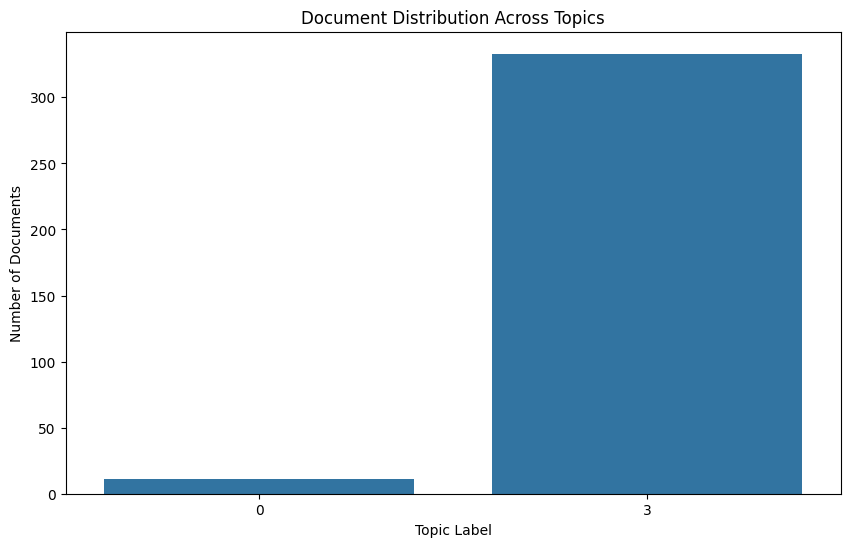

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of documents across topics
plt.figure(figsize=(10, 6))
sns.countplot(x='topic_label', data=df_month)
plt.title('Document Distribution Across Topics')
plt.xlabel('Topic Label')
plt.ylabel('Number of Documents')
plt.show()
